# Import packages

In [2]:
import yt
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import logging
logging.getLogger("yt").setLevel(logging.WARNING)
import os
import imageio.v2 as imageio
import glob
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.image import imread
import matplotlib.animation as animation

# Basic plotting tool


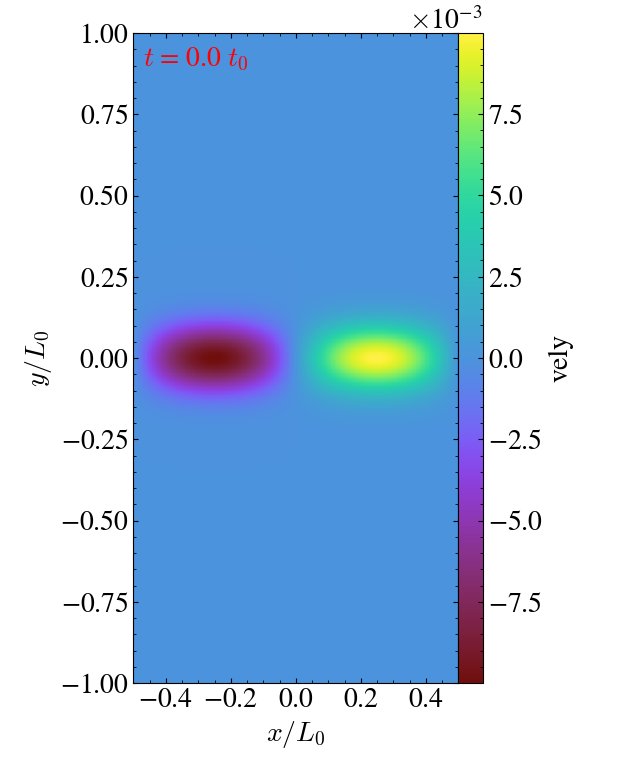

In [81]:
data = yt.load("higher_res/KHI_mhd_2d_hdf5_chk_0000")

quantity = 'vely'
field = ('flash', quantity)
label = quantity
colormap = 'rainbow'

p = yt.SlicePlot(data, "z", field, center=[0.0, 0.0, 0.0])
p.set_figure_size(6.5)
p.set_log(field, False)
#p.set_cmap(field, colormap)
p.set_font_size(20)
p.set_xlabel("$x/L_0$")
p.set_ylabel("$y/L_0$")
p.set_colorbar_label(field, label)

sim_time = data.current_time.value
p.annotate_text((0.03, 0.95), f"$t$ = {sim_time:.1f} $t_0$", 
                coord_system='axis', text_args={'color': 'red'})

#p.set_zlim(field, 0, 3)
#p.annotate_contour(field, levels=20, take_log=False,
#                   plot_args={"colors": "white", "linewidths": 0.5})
p.show()
#fig = p.plots[field].figure
#fig.savefig("dens_slice.png", dpi=600, bbox_inches='tight')

In [8]:
data.print_stats()

level	# grids	       # cells	     # cells^3
----------------------------------------------
  0	   128	         32768	            32
----------------------------------------------
   	   128	         32768


t = 2.01961011e-01 code_time = 2.01961011e-01 s = 6.39975825e-09 yr

Smallest Cell:
	Width: 2.532e-27 Mpc
	Width: 2.532e-21 pc
	Width: 5.222e-16 AU
	Width: 7.812e-03 cm


# B field map


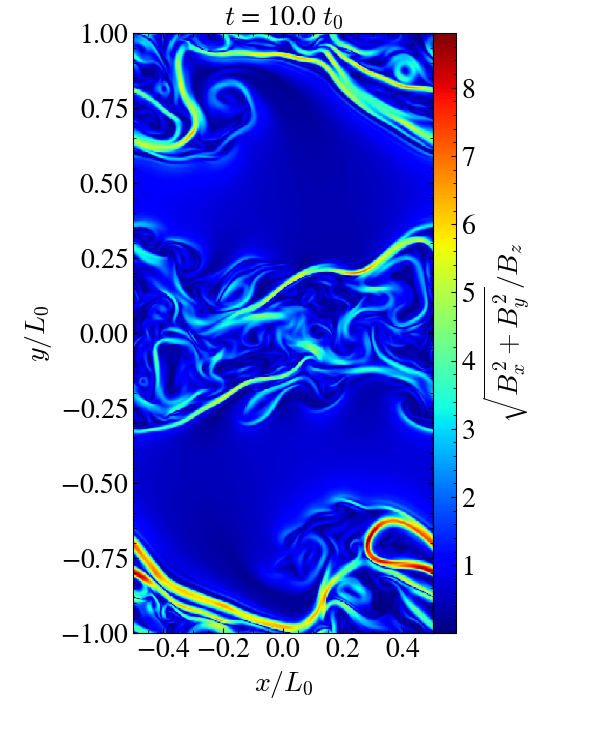

In [79]:
data = yt.load("higher_res/KHI_mhd_2d_hdf5_chk_0050")

# Define the derived field
def Bperp_over_Bz(field, data):
    Bx = data[("flash", "magx")]
    By = data[("flash", "magy")]
    Bz = data[("flash", "magz")]
    return np.sqrt(Bx**2 + By**2) / Bz 

yt.add_field(("flash", "Bperp_over_Bz"), function=Bperp_over_Bz,
             sampling_type="cell", force_override=True)

# Now plot
field = ('flash', 'Bperp_over_Bz')
label = r"$\sqrt{B_x^2 + B_y^2}/B_z$"

p = yt.SlicePlot(data, "z", field, center=[0.0, 0.0, 0.0])
p.set_figure_size(6)
p.set_log(field, False)
p.set_font_size(20)
p.set_xlabel("$x/L_0$")
p.set_ylabel("$y/L_0$")
p.set_colorbar_label(field, label)
p.set_cmap(field, 'jet')

sim_time = data.current_time.value
p.annotate_title(f"$t$ = {sim_time:.1f} $t_0$")
p.show()

# Evolution of the magnetic pressure

In [34]:
times = []
B2_avg = []

for i in range(1, 101, 1):  # files from 1 to 100, every 2
    file = f"KHI_mhd_2d_hdf5_chk_{i:04d}"
    try:
        ds = yt.load(file)
        ad = ds.all_data()

        Bx = ad[("flash", "magx")]
        By = ad[("flash", "magy")]
        Bz = ad[("flash", "magz")]

        B2 = (Bx**2 + By**2 + Bz**2)/Bz**2

        avg_B2 = np.average(B2)

        times.append(ds.current_time.to_value())  # remove .to_value() if already float
        B2_avg.append(avg_B2)

        #print(f"{file}: <B^2> = {avg_B2:.4e} at t = {ds.current_time:.2f}")

    except FileNotFoundError:
        print(f"{file} not found, skipping.")

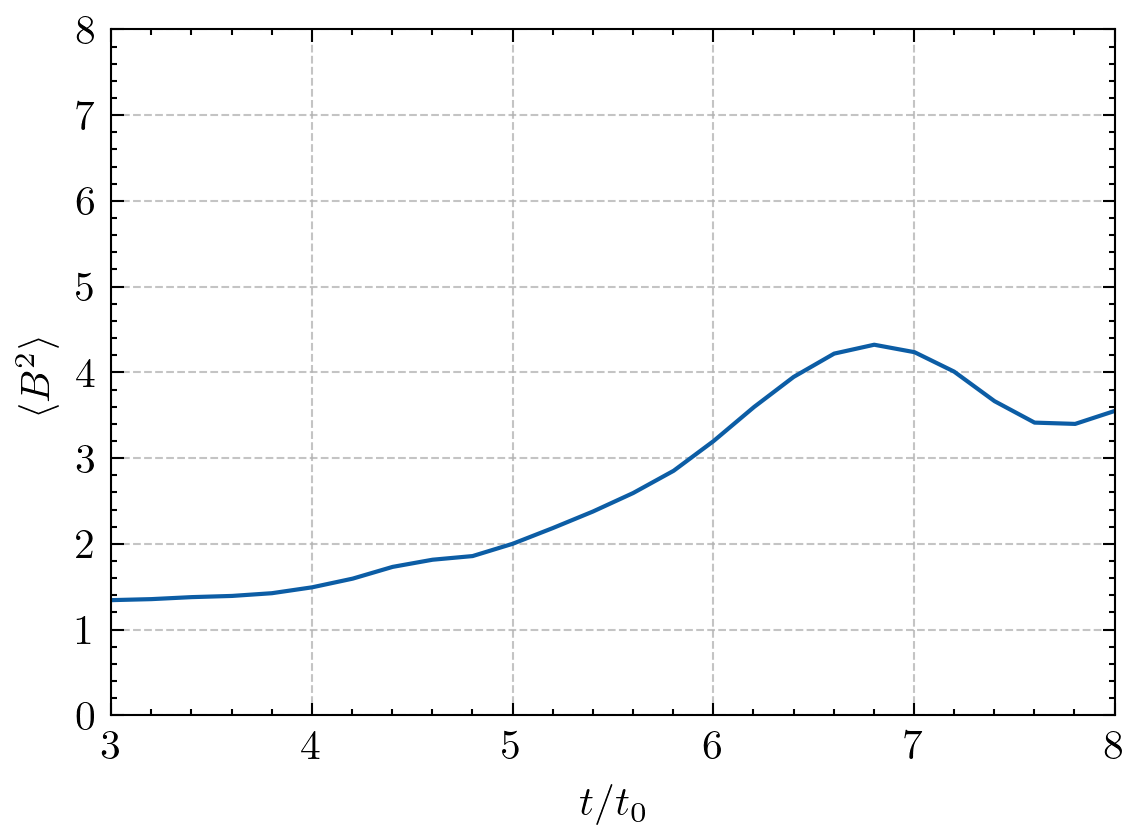

In [38]:
# Plot
with plt.style.context('science'):
    plt.figure(figsize=(4, 3), dpi = 300)
    plt.plot(times, B2_avg)
    plt.xlabel(r"$t/t_0$")
    plt.ylabel(r"$\langle B^2 \rangle$")
    plt.grid(linestyle='--', alpha=0.75)
    plt.xlim(3,8)
    plt.ylim(0, 8)
    plt.tight_layout()
    plt.show()

# Make vid

In [69]:
# Create directory for frames
os.makedirs("frames", exist_ok=True)

# Parameters
field = ("flash", "Bperp_over_Bz")
colormap = "jet"
vmin, vmax = 0, 7

# Generate each frame
for i in range(0, 101, 5):
    filename = f"KHI/KHI_mhd_2d_hdf5_chk_{i:04d}"
    try:
        ds = yt.load(filename)
        p = yt.SlicePlot(ds, "z", field, center=[0.0, 0.0, 0.0])
        p.set_figure_size(6)
        p.set_log(field, False)
        p.set_cmap(field, colormap)
        p.set_zlim(field, vmin, vmax)
        p.set_font_size(20)
        p.set_colorbar_label(field, r"$\sqrt{B_x^2 + B_y^2}/B_z$")
        p.set_xlabel("$x/L_0$")
        p.set_ylabel("$y/L_0$")

        sim_time = ds.current_time.value
        p.annotate_title(f"$t$ = {sim_time:.1f} $t_0$")
   
        p._setup_plots()
        fig = p.plots[field].figure
        fig.savefig(f"frames/frame_{i:04d}.png", dpi=300, bbox_inches='tight')
        plt.close(fig)

    except FileNotFoundError:
        print(f"⚠File not found: {filename}")

✅ Video saved as B_evolution.mp4


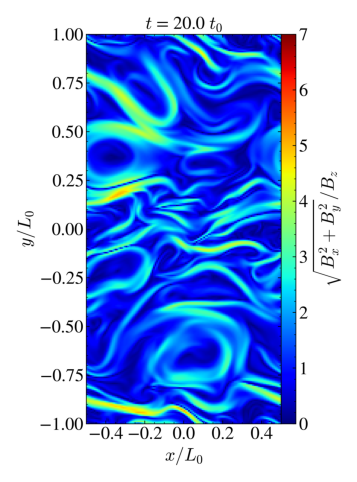

In [70]:
# Get list of PNG frames
frame_files = sorted(glob.glob("frames/frame_*.png"))

# Read the first frame to get shape
img_data = imread(frame_files[0])
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(img_data)
ax.axis("off") 

def update(frame_path):
    im.set_data(imread(frame_path))
    return [im]

ani = animation.FuncAnimation(
    fig, update, frames=frame_files, blit=True, repeat=False)

# Save using FFMpegWriter
writer = animation.FFMpegWriter(fps=8)
ani.save("B_evolution.mp4", writer=writer)

print("✅ Video saved as B_evolution.mp4")
